# Keeping relevant labels from extended atlas

Since the extended atlas has 82 labels, we don't want to use all of them (most won't be relevant for our analysis). <br>
However, some are relevant.<br>
Here, we mainly keep the original annotations, but additionally use some of the extended atlas labels for relevant cell-types.



In [3]:
suppressPackageStartupMessages({
    library(dplyr)
    library(data.table)
    library(ggplot2)
})

here::i_am("mapping/analysis/01_Combine_atlas_labels.ipynb")

# Load default settings
source(here::here("settings.R"))
source(here::here("utils.R"))

set.seed(1234)

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/12_Eomes_T_Mixl1/T/code



In [4]:
meta = fread(paste0(io$basedir,"/results/rna/mapping/manual/sample_metadata_after_mapping.txt.gz"))

In [5]:
compare = data.table(cell = meta$cell, original = meta$celltype.mapped_mnn, extended = meta$celltype_extended.mapped_mnn) %>%
    .[,count := .N, by=c('original', 'extended')] %>%
    .[,tot := .N, by='original'] %>% .[,prop := count/tot] %>%
    unique(by=c('original', 'extended')) 

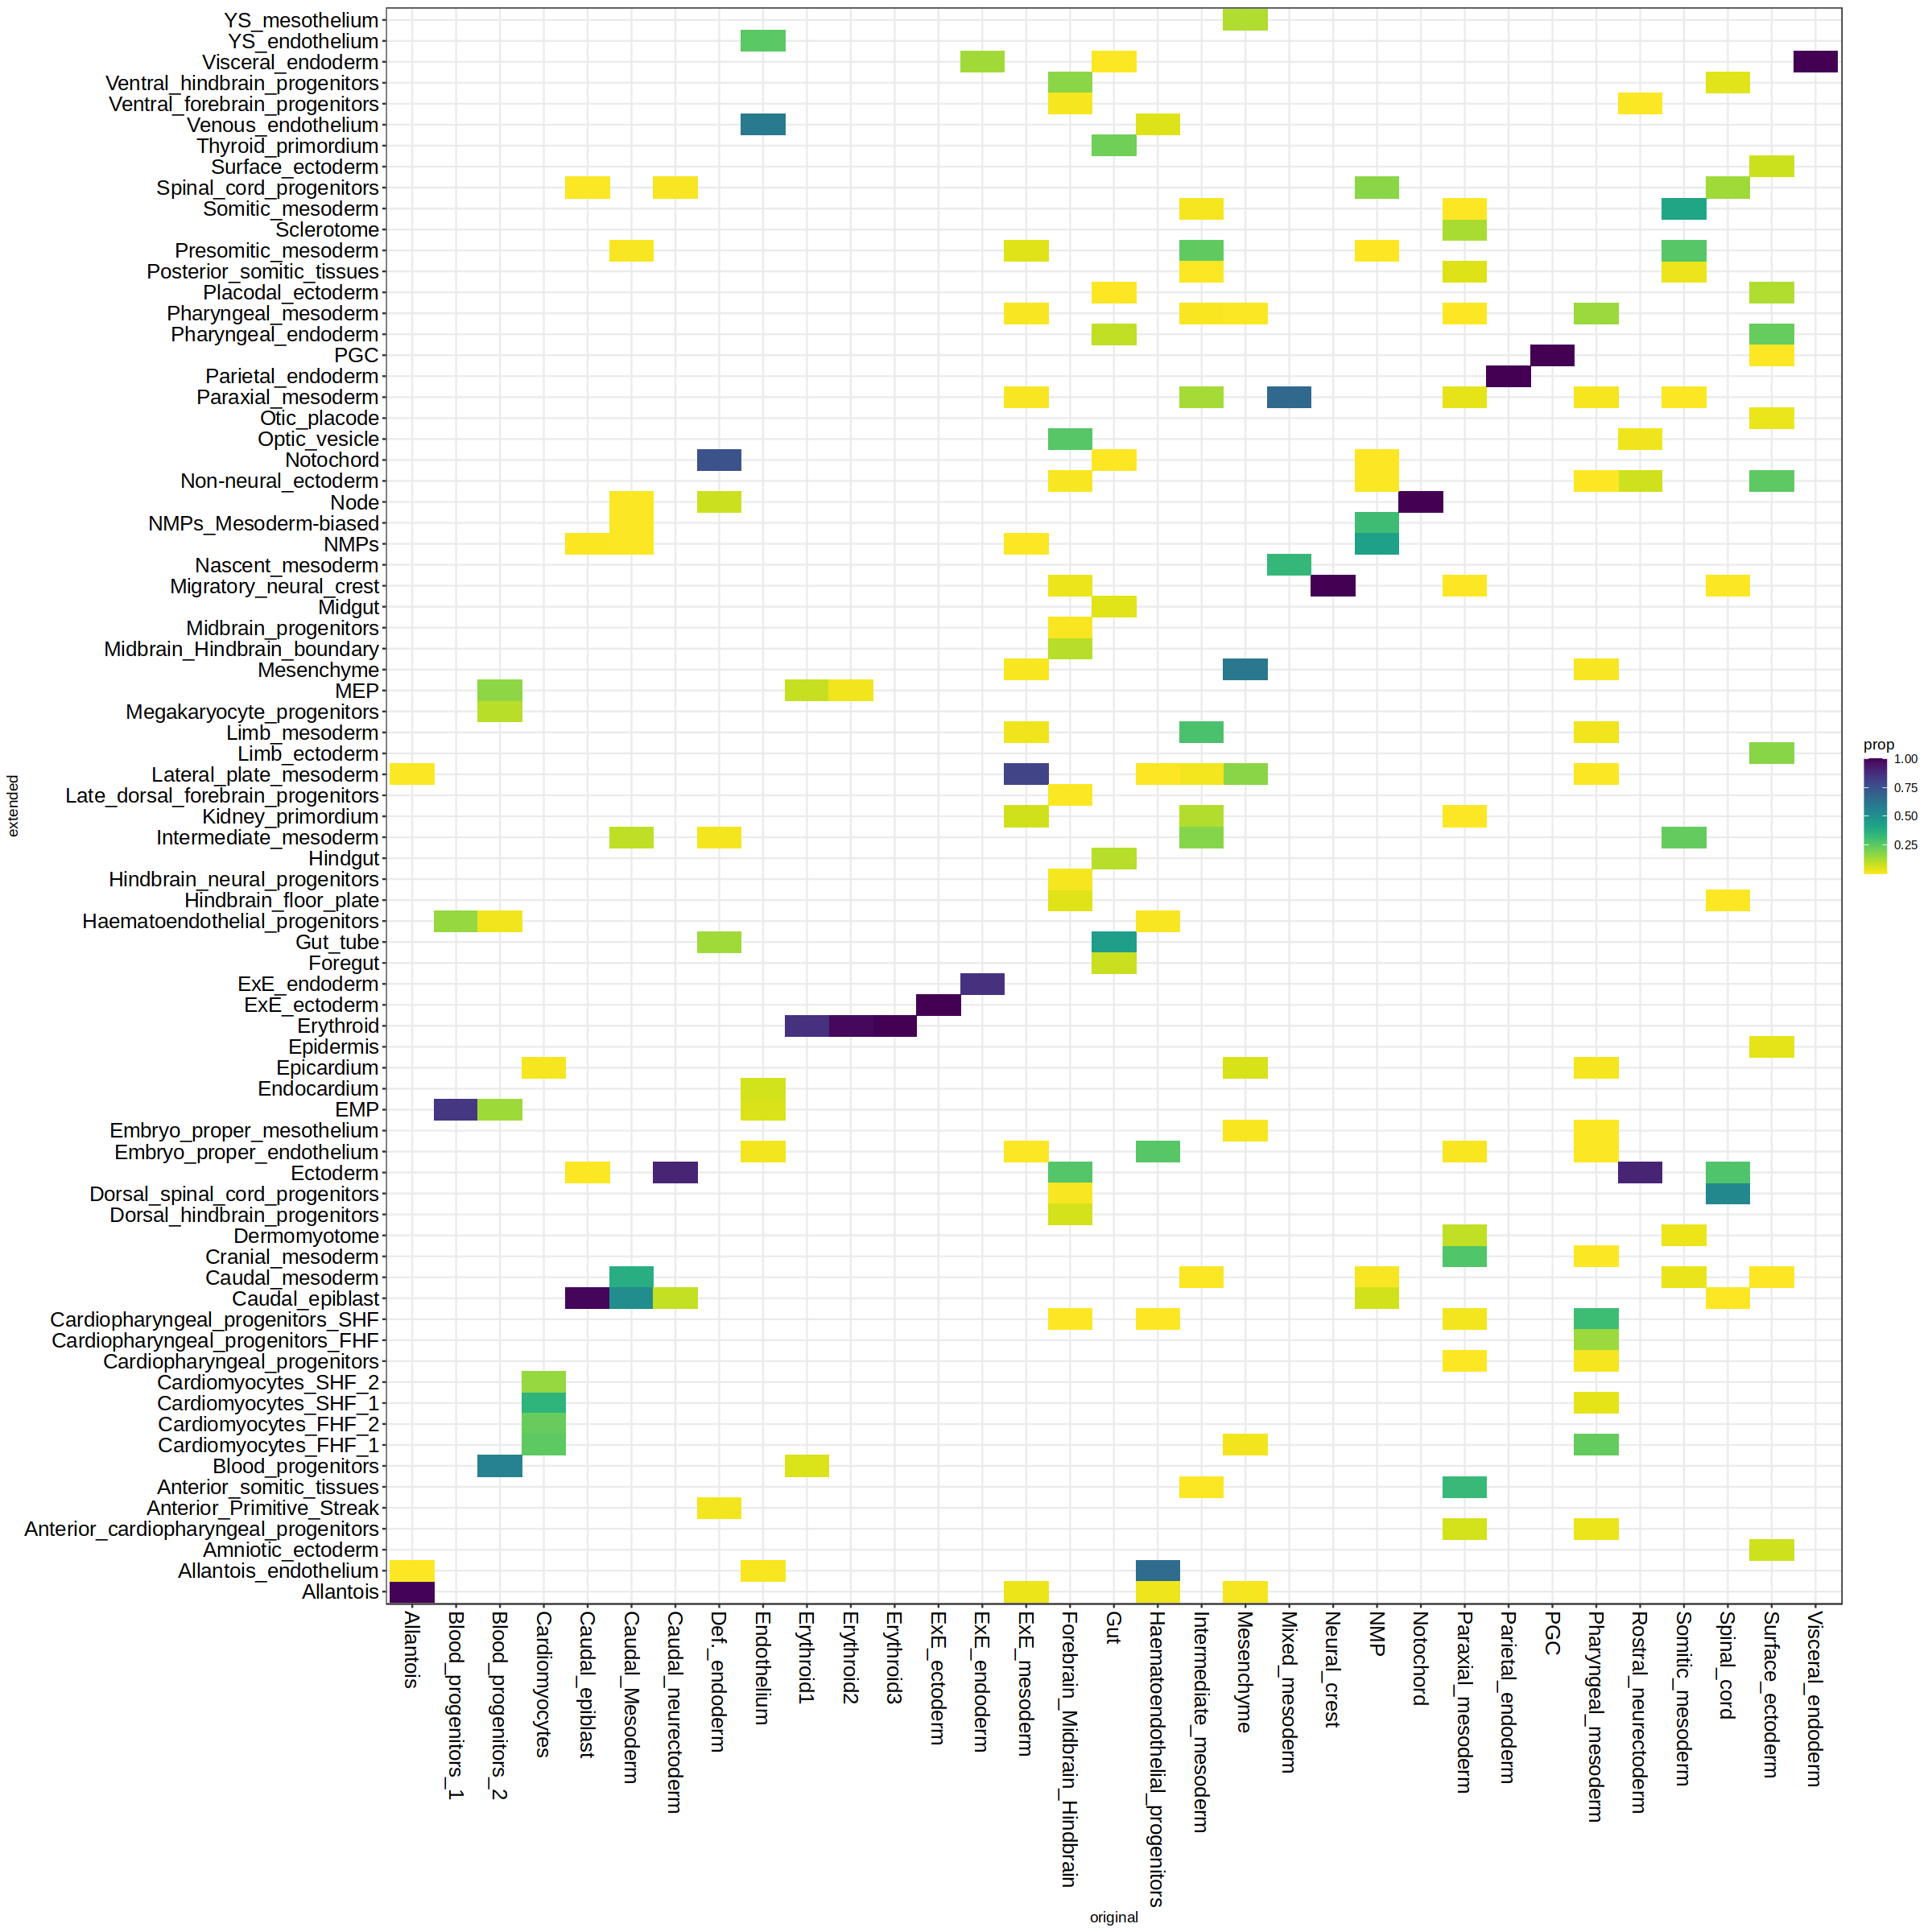

In [6]:
options(repr.plot.width=20, repr.plot.height=20)
ggplot(compare[!is.na(original)], aes(original, extended, fill=prop)) + 
    geom_tile() + 
    viridis::scale_fill_viridis(begin=1, end=0) + 
    theme_bw() + 
    theme(axis.text.x = element_text(angle=-90, hjust=0, vjust=0.5),
          axis.text = element_text(color='black', size=15))

In [7]:
original_keep = c('Allantois', 
                  paste0('Blood_progenitors_', 1:2),
                  'Cardiomyocytes',
                  'Caudal_epiblast',
                  'Caudal_Mesoderm',
                  'Caudal_neurectoderm',
                  'Def._endoderm',
                  'Epiblast',
                  'ExE_ectoderm',
                  'ExE_endoderm',
                  'Forebrain_Midbrain_Hindbrain',
                  'Gut',
                  'Nascent_mesoderm',
                  'Neural_crest',
                  'NMP',
                  'Notochord', 
                  'Parietal_endoderm',
                  'PGC',
                  'Pharyngeal_mesoderm',
                  'Rostral_neurectoderm', 
                  'Spinal_cord',
                  'Surface_ectoderm', # Except for amniotic ectoderm
                  'Visceral_endoderm'                  
                )
original_replace = c('Endothelium',
                    paste0('Erythroid', 1:3), # --> Erythroid
                    'ExE_mesoderm', # --> Replace with LPM all together
                     'Haematoendothelial_progenitors',# --> Use exteended atlas label
                   'Mixed_mesoderm' # Use the new labels as they are more precise
                )


In [8]:
meta = meta[,celltype_updated := celltype.mapped_mnn] %>% 
    # Add higher resolution endothelium annotation
    .[,celltype_updated := ifelse(celltype_updated %in% c('Endothelium', 'Haematoendothelial_progenitors'), celltype_extended.mapped_mnn, celltype_updated), ] %>% 
    # Merge Erythroids 
    .[,celltype_updated := ifelse(celltype_updated %in% paste0('Erythroid', 1:3), 'Erythroid', celltype_updated)] %>%
    # Change 'ExE mesoderm' to 'Lateral plate mesoderm'
    .[,celltype_updated := ifelse(celltype_updated == 'ExE_mesoderm', 'Lateral_plate_mesoderm', celltype_updated)] %>% 
    # Improve mixed mesoderm annotation
    .[,celltype_updated := ifelse(celltype_updated == 'Mixed_mesoderm', celltype_extended.mapped_mnn, celltype_updated)] %>% 
    # Add amniotic ectoderm    
    .[,celltype_updated := ifelse(celltype_extended.mapped_mnn == 'Amniotic_ectoderm', 'Amniotic_ectoderm', celltype_updated)] %>%
    # Add YS mesothelium
    .[,celltype_updated := ifelse(celltype_extended.mapped_mnn == 'YS_mesothelium', 'YS_mesothelium', celltype_updated)]

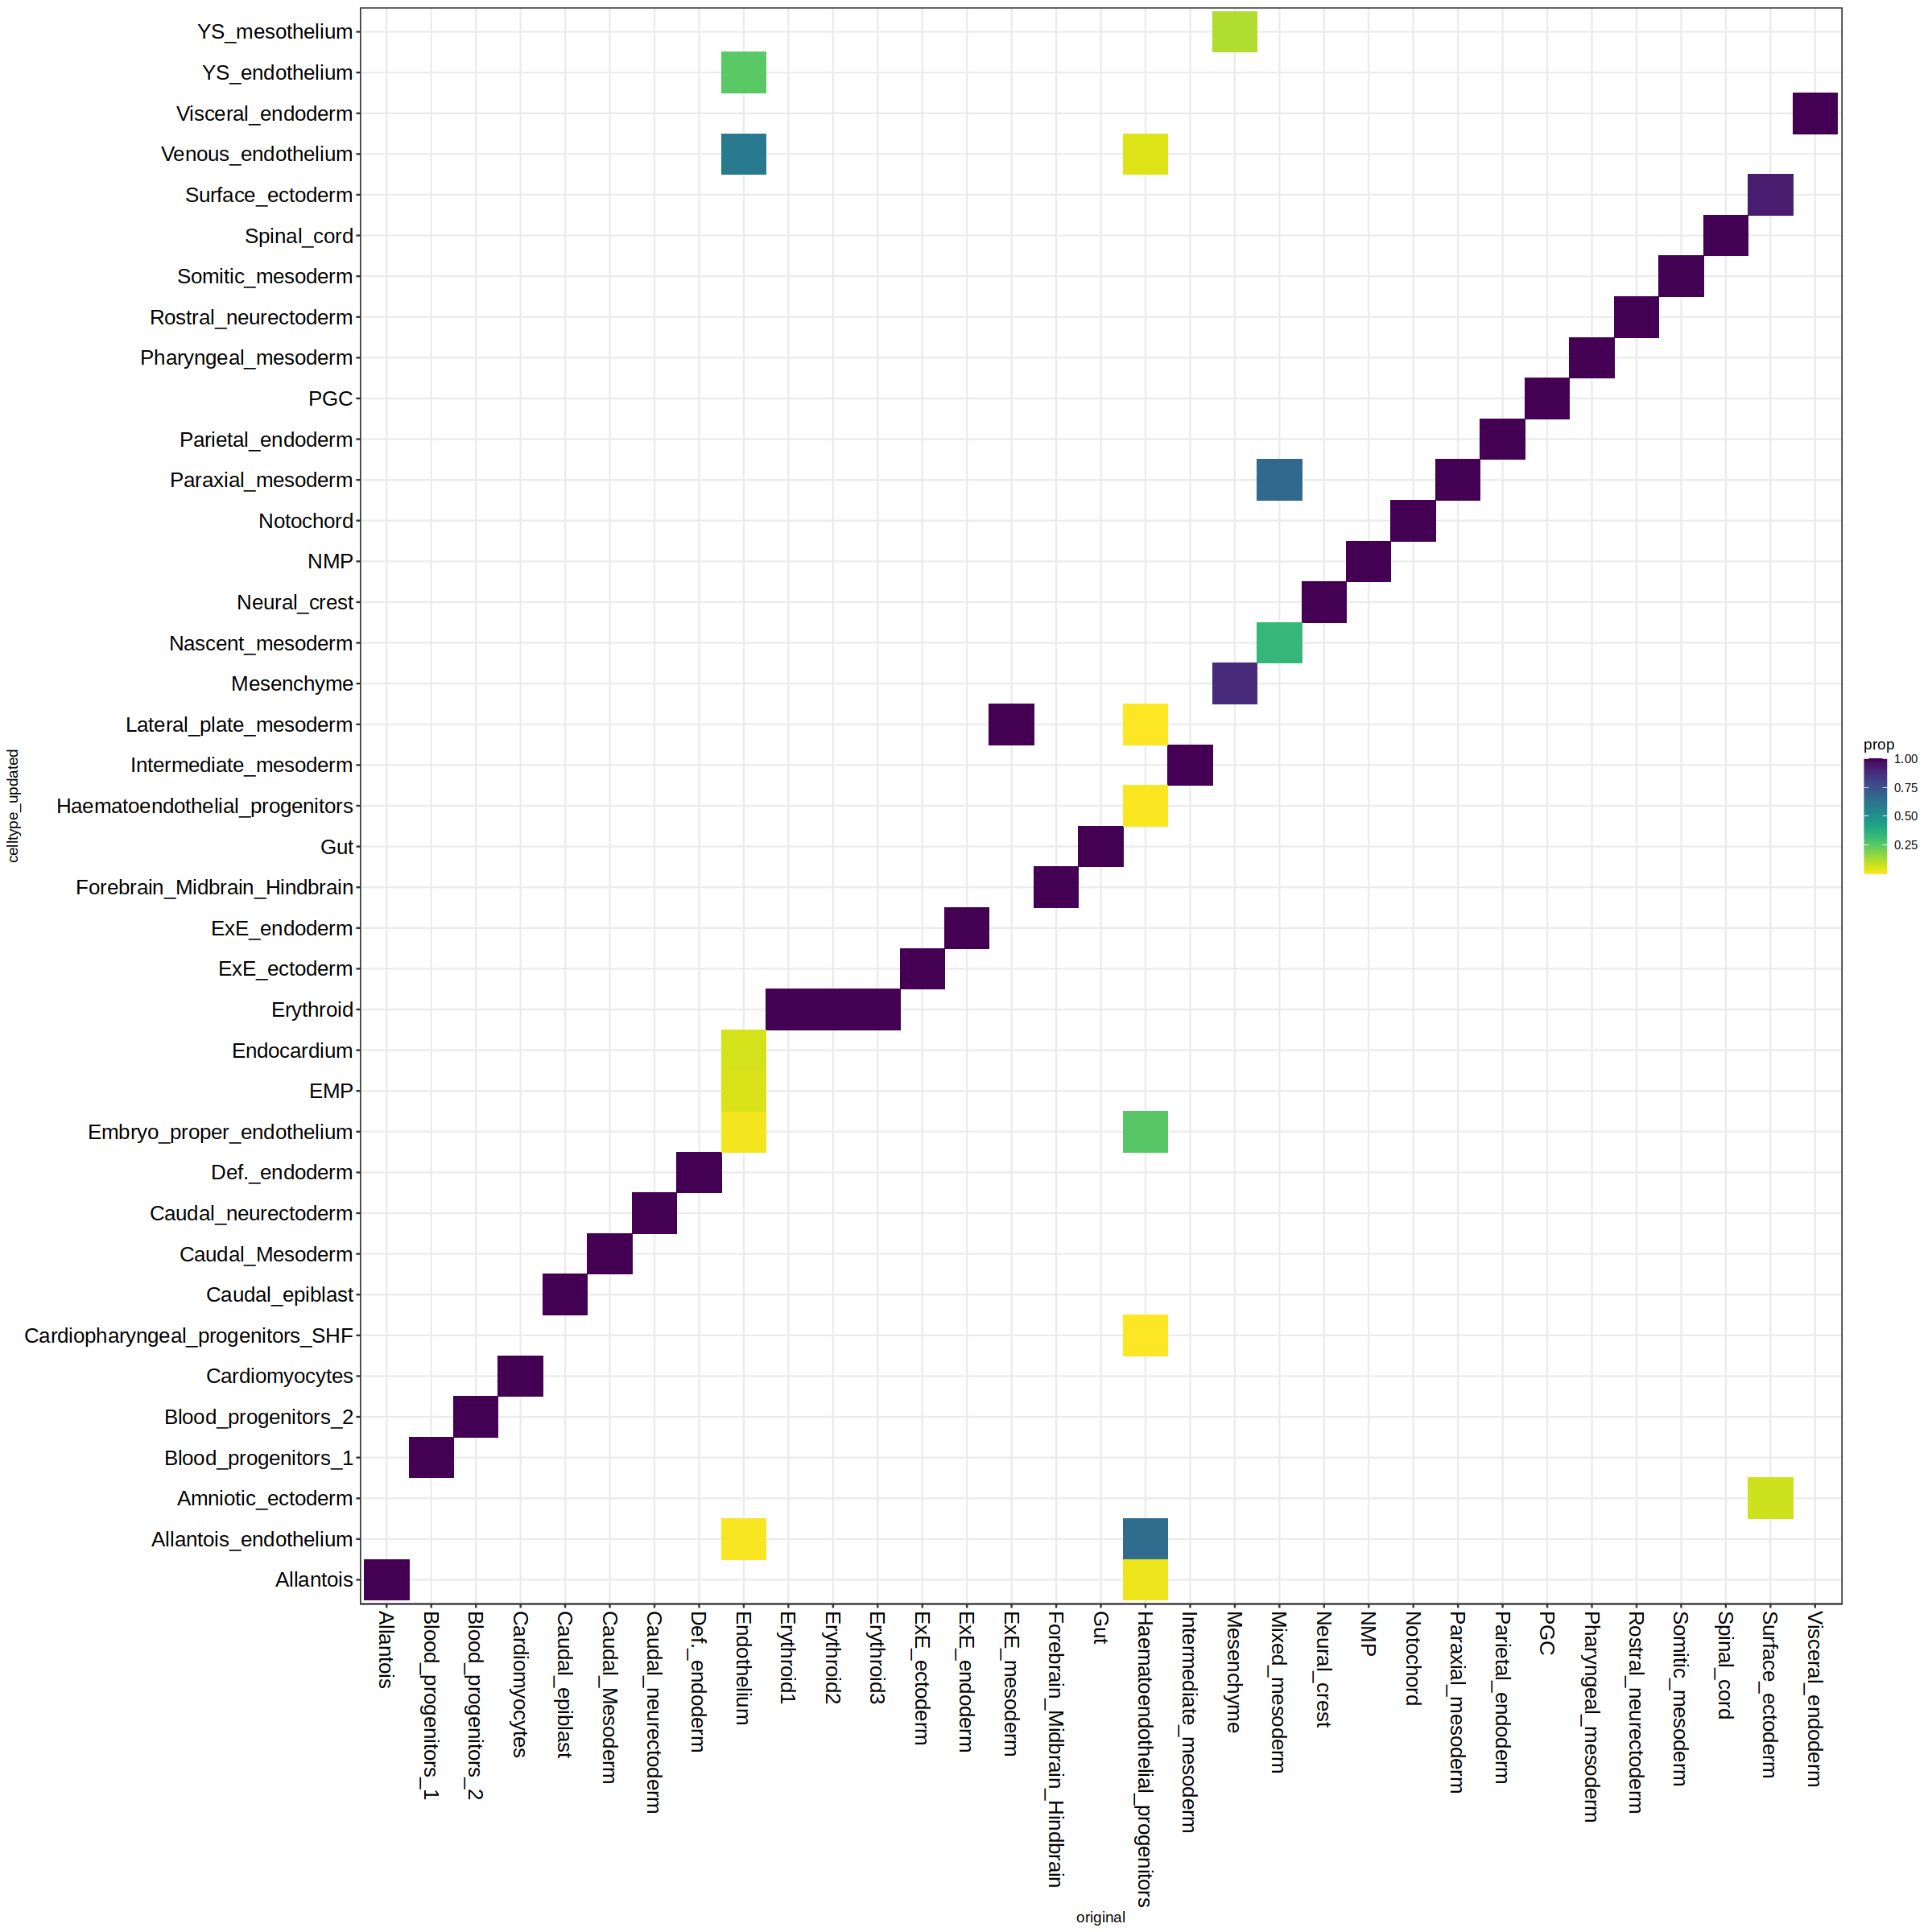

In [9]:
compare = data.table(cell = meta$cell, original = meta$celltype.mapped_mnn, celltype_updated = meta$celltype_updated) %>%
    .[,count := .N, by=c('original', 'celltype_updated')] %>%
    .[,tot := .N, by='original'] %>% .[,prop := count/tot] %>%
    unique(by=c('original', 'celltype_updated')) 

options(repr.plot.width=20, repr.plot.height=20)
ggplot(compare[!is.na(original)], aes(original, celltype_updated, fill=prop)) + 
    geom_tile() + 
    viridis::scale_fill_viridis(begin=1, end=0) + 
    theme_bw() + 
    theme(axis.text.x = element_text(angle=-90, hjust=0, vjust=0.5),
          axis.text = element_text(color='black', size=15))

In [10]:
# Load cell metadata
args = list()
args$atlas_metadata = '/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation/pijuansala2019_gastrulation10x/sample_metadata_extended.txt.gz'
meta_atlas <- fread(args$atlas_metadata)

In [11]:
meta = merge(meta, meta_atlas[,c('cell', 'umapX','umapY')], by.x='closest.cell_mnn', by.y='cell')

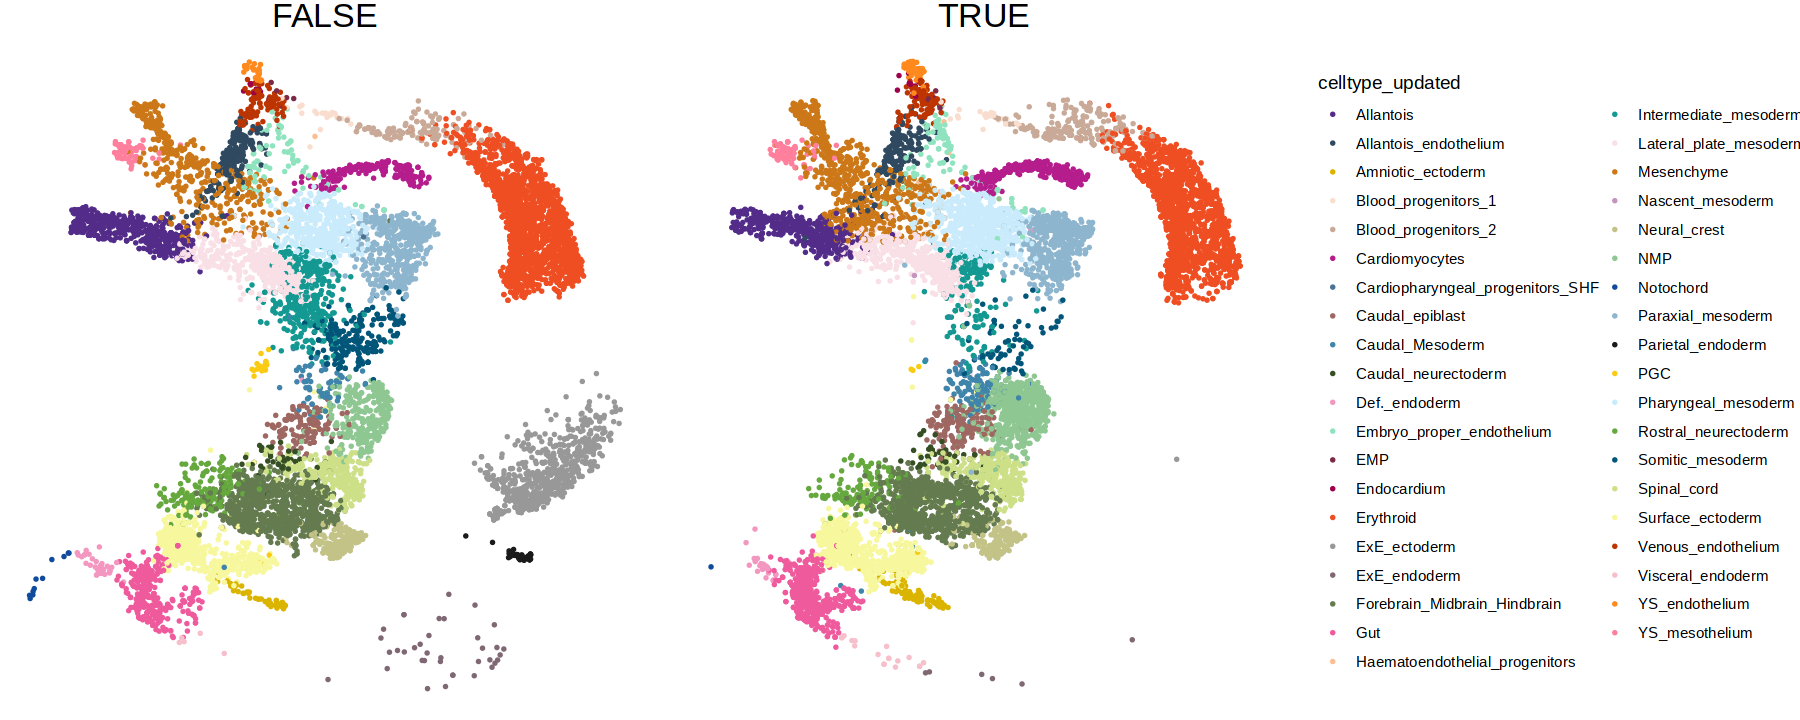

In [12]:
options(repr.plot.width=15, repr.plot.height=6)
ggplot(meta, aes(umapX, umapY, color=celltype_updated)) + 
    geom_point(size=0.5) + 
    scale_color_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    facet_wrap(~tdTom) + 
    theme_void() + 
    theme(legend.position='right',
          strip.background=element_blank(),
          strip.text=element_text(size=20))

In [29]:
fwrite(meta, paste0(io$basedir, '/results/rna/mapping/manual/metadata_mapping_updated.txt.gz'))

In [15]:
p = ggplot(meta, aes(umapX, umapY, color=celltype_updated)) + 
    geom_point(data = rbind(meta_atlas %>% copy() %>% .[,tdTom:=FALSE], meta_atlas %>% copy() %>% .[,tdTom:=TRUE]), 
               color='grey90') + 
    scale_color_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    geom_point(size=0.5) + 
    facet_wrap(~tdTom) + 
    theme_void() + 
    theme(legend.position='right',
          strip.background=element_blank(),
          strip.text=element_text(size=20))

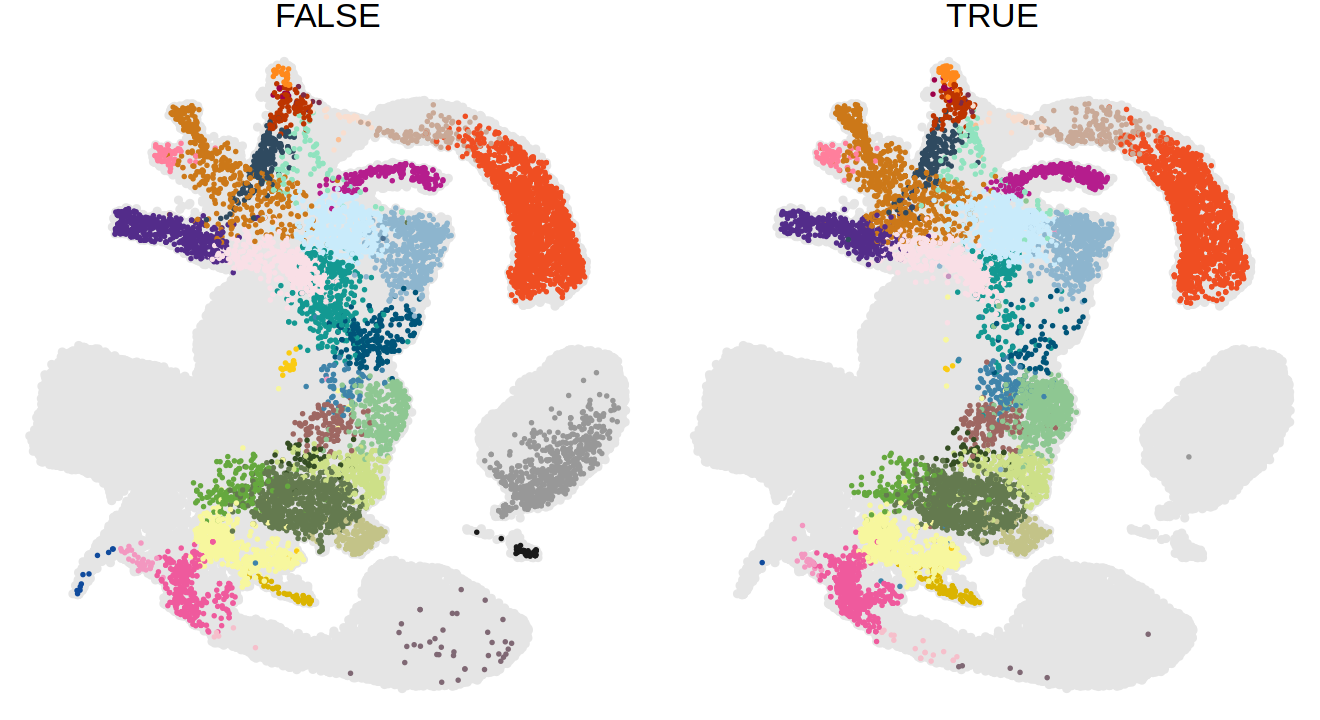

In [16]:
options(repr.plot.width=11)
p + theme(legend.position = 'none')

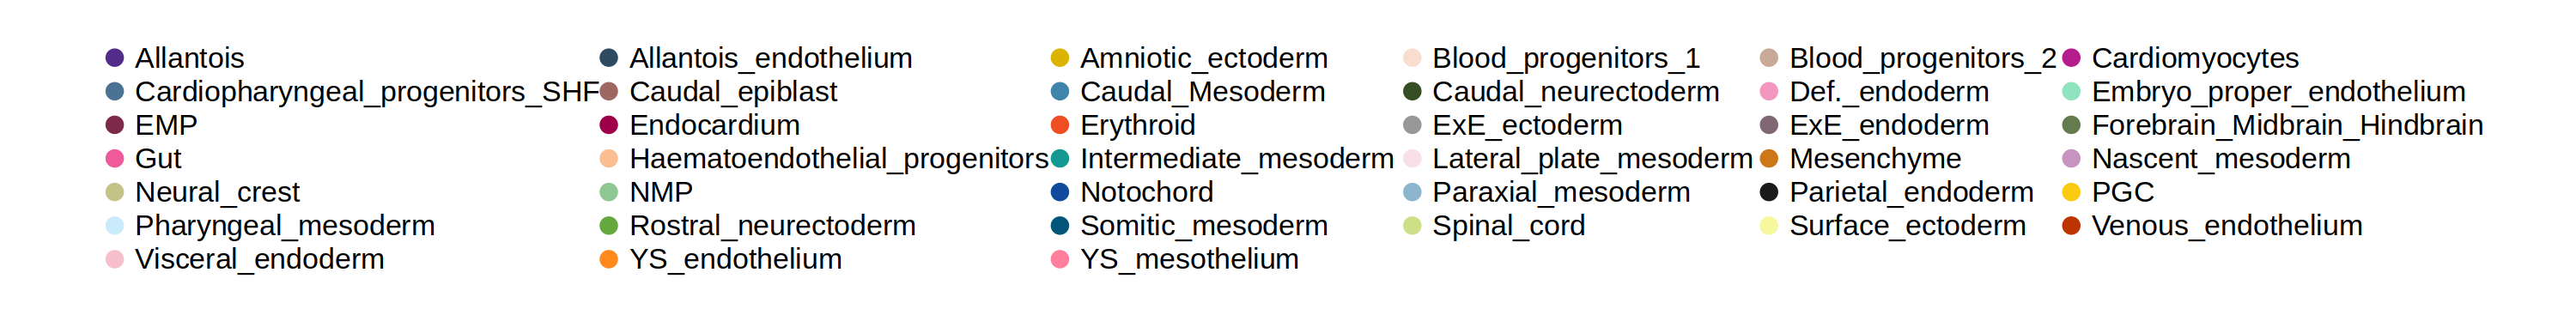

In [17]:
options(repr.plot.width=25, repr.plot.height=3)
celltype_legend = as_ggplot(get_legend(ggplot(meta, aes(umapX, umapY, color=celltype_updated)) +
                geom_point(size=5) + 
                scale_color_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
                guides(color=guide_legend(nrow=7, byrow=TRUE)) +
                theme_void() + 
                theme(legend.text = element_text(size=20),
                      legend.title = element_blank())))
celltype_legend

### Celltype proportions

In [18]:
celltype2germlayer = c(
    'Amniotic_ectoderm' = 'ectoderm', 
    'Surface_ectoderm' = 'ectoderm', 
    'Caudal_neurectoderm' = 'ectoderm',
    'Rostral_neurectoderm' = 'ectoderm', 
    'Spinal_cord' = 'ectoderm', 
    'NMP' = 'ectoderm', 
    'Forebrain_Midbrain_Hindbrain' = 'ectoderm', 
    'Neural_crest' = 'ectoderm', 

    'Notochord' = 'endoderm', 
    'Def._endoderm' = 'endoderm', 
    'Gut' = 'endoderm', 

    'PGC' = 'other', 
    'Caudal_epiblast' = 'other', 
    'Mixed' = 'other', 

    'Intermediate_mesoderm' = 'mesoderm', 
    'Nascent_mesoderm' = 'mesoderm', 
    'Lateral_plate_mesoderm' = 'mesoderm', 
    'Allantois' = 'mesoderm', 
    'Somitic_mesoderm' = 'mesoderm', 
    'Caudal_Mesoderm' = 'mesoderm', 
    'Mesenchyme' = 'mesoderm', 
    'Pharyngeal_mesoderm' = 'mesoderm', 
    'Paraxial_mesoderm' = 'mesoderm', 
    'Cardiomyocytes' = 'mesoderm', 
    'Venous_endothelium' = 'mesoderm', 
    'Embryo_proper_endothelium' = 'mesoderm', 
    'Allantois_endothelium' = 'mesoderm', 
    'YS_endothelium' = 'mesoderm', 
    'Blood_progenitors_1' = 'mesoderm', 
    'Blood_progenitors_2' = 'mesoderm',
    'Erythroid' = 'mesoderm'
)

In [19]:
meta = fread('/rds/project/rds-SDzz0CATGms/users/bt392/01_Eomes_RNA/results/rna/mapping/manual/metadata_mapping_updated.txt.gz')%>%
    .[!celltype_updated%in%c("Visceral_endoderm","ExE_endoderm","ExE_ectoderm","Parietal_endoderm")] %>%
    .[,pool:=stringr::str_replace_all(sample,opts$sample2pool)]

In [20]:
table(meta$tdTom)


FALSE  TRUE 
11452 12962 

In [21]:
table(meta$tdTom, meta$celltype_updated)

       
        Allantois Allantois_endothelium Amniotic_ectoderm Blood_progenitors_1
  FALSE       654                   284                53                  29
  TRUE        606                   209               104                  28
       
        Blood_progenitors_2 Cardiomyocytes Cardiopharyngeal_progenitors_SHF
  FALSE                 132            222                                1
  TRUE                  222            428                                0
       
        Caudal_epiblast Caudal_Mesoderm Caudal_neurectoderm Def._endoderm
  FALSE             144              76                  53            38
  TRUE              223             213                  49            26
       
        Embryo_proper_endothelium  EMP Endocardium Erythroid
  FALSE                        91    6           8      3029
  TRUE                        111   10          11      2463
       
        Forebrain_Midbrain_Hindbrain  Gut Haematoendothelial_progenitors
  FALSE             

In [22]:
tmp = meta %>% copy() %>% 
    .[,tot := .N, by = 'sample'] %>% 
    .[,prop := .N/tot, by = c('sample', 'celltype_updated')] %>% 
    unique(by = c('sample', 'celltype_updated'))

all = merge(as.data.table(expand.grid(unique(tmp$sample), unique(tmp$celltype_updated))) %>% 
                        setnames(c('sample', 'celltype_updated')),
          tmp %>% copy() %>% .[,c('sample', 'tdTom', 'pool')] %>% unique(by='sample'), by = 'sample'
           )

tmp = merge(tmp, all, by=c('sample', 'celltype_updated', 'tdTom', 'pool'), all = TRUE) %>% 
        replace(., is.na(.), 0)

In [24]:
# Calculate differential abundance statistics
tmp = meta %>% copy() %>% 
    .[,tot := .N, by = 'sample'] %>% 
    .[,prop := .N/tot, by = c('sample', 'celltype_updated')] %>% 
    unique(by = c('sample', 'celltype_updated'))

all = merge(as.data.table(expand.grid(unique(tmp$sample), unique(tmp$celltype_updated))) %>% 
                        setnames(c('sample', 'celltype_updated')),
          tmp %>% copy() %>% .[,c('sample', 'tdTom', 'pool')] %>% unique(by='sample'), by = 'sample'
           )

tmp = merge(tmp, all, by=c('sample', 'celltype_updated', 'tdTom', 'pool'), all = TRUE) %>% 
         replace(., is.na(.), 0)
        #replace(., is.na(.), 1e-3)

tmp2 = merge(tmp %>% copy() %>%
                .[tdTom == TRUE] %>% 
                .[,c('pool', 'celltype_updated', 'prop')] %>% setnames('prop', 'KO'),
             tmp %>% copy() %>%
                .[tdTom == FALSE] %>% 
                .[,c('pool', 'celltype_updated', 'prop')] %>% setnames('prop', 'WT'),
             by = c('pool', 'celltype_updated'), keep.all=TRUE
             ) %>% 
     .[,log2fc := log2((KO+1e-5)/(WT+1e-5))] %>% 
    #.[,fc := (KO)/(WT)] %>% 
    .[KO>0 | WT > 0] # remove pools where both are 0

stats = lapply(unique(tmp2$celltype_updated), function(x){
    tmp3 = tmp2 %>% copy() %>% 
            .[celltype_updated == x]
    if(nrow(tmp3) > 1){
        tmp4 = data.table(celltype_updated = x,
                          avg_log2fc = mean(tmp3$log2fc),
                          sd_log2fc = sd(tmp3$log2fc),
                          #p_value = t.test(tmp3$KO, tmp3$WT, paired=TRUE, alternative = "two.sided")$p.value,
                          p_value = t.test(tmp3$log2fc)$p.value,
                          #p_value = t.test(tmp3$fc, mu=1)$p.value,
                          samples = nrow(tmp3))
    } else{
        tmp4 = data.table(celltype_updated = x,
                  avg_log2fc = mean(tmp3$log2fc),
                  sd_log2fc = NA,
                  p_value = NA,
                  samples = 1)
    }
    return(tmp4)
}) %>% rbindlist() %>% 
    .[,FDR := p.adjust(p_value, n=nrow(.), method='fdr')] %>% 
    .[,germ_layer := celltype2germlayer[as.character(celltype_updated)]] %>% 
    .[,sig := ifelse(FDR <= 0.05, TRUE, FALSE)]


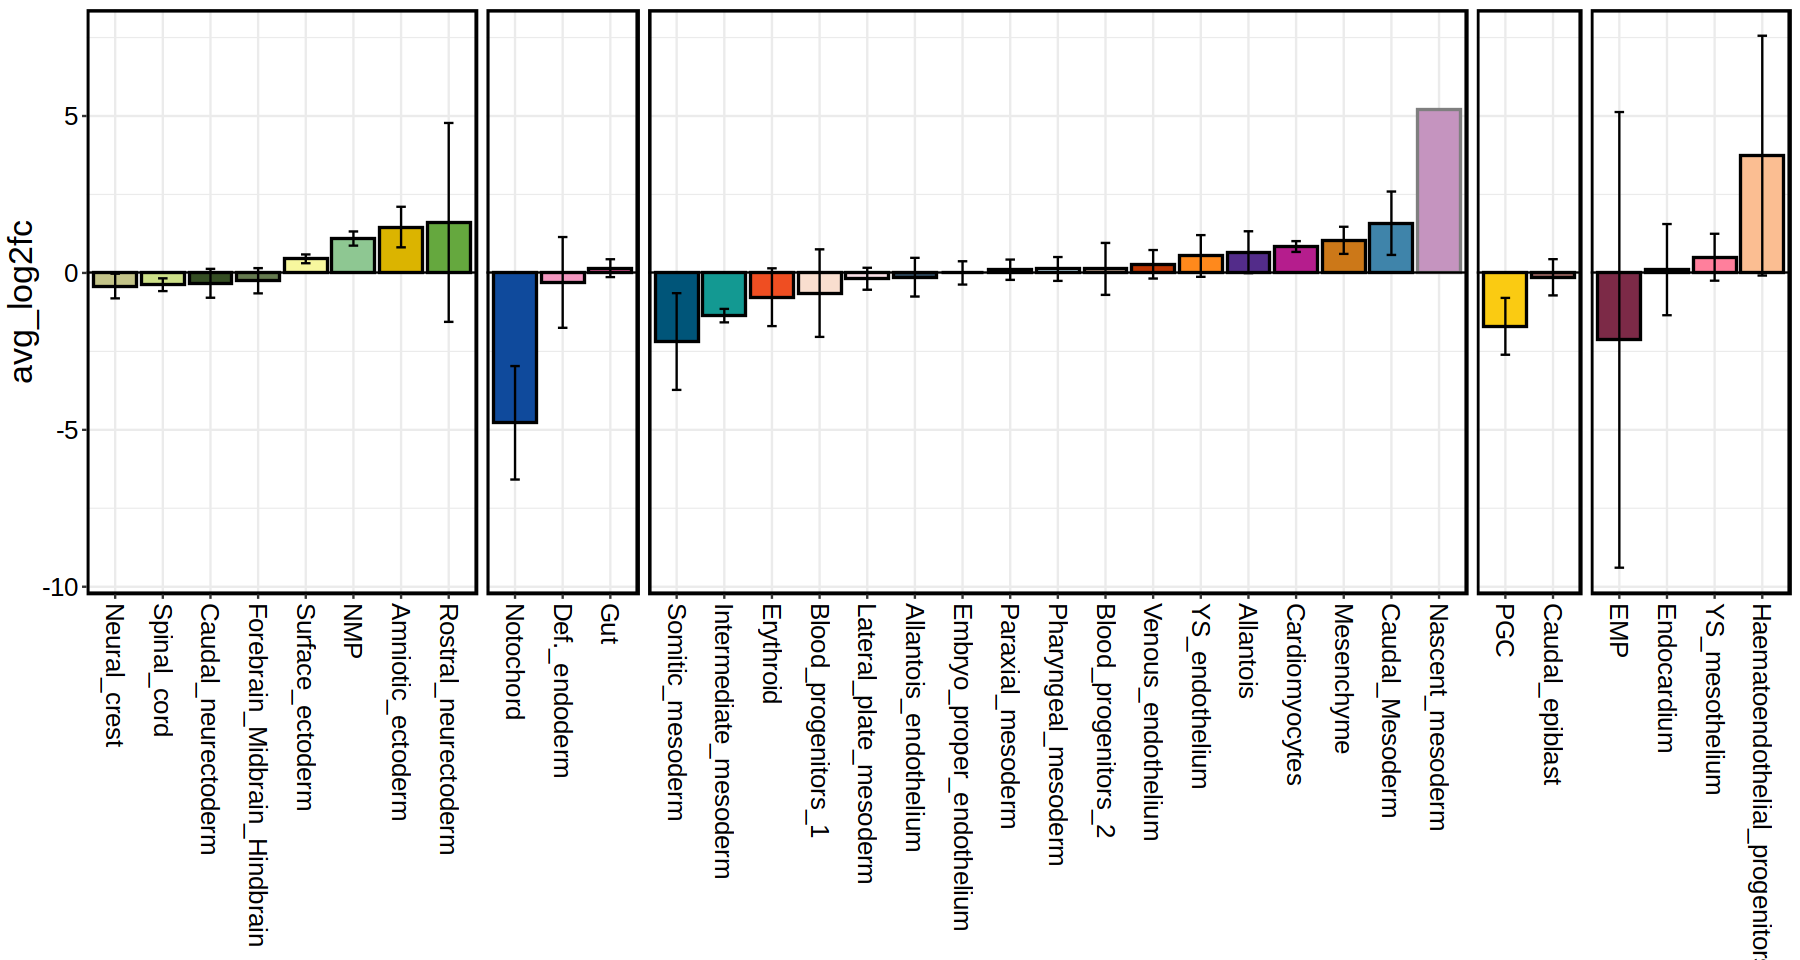

In [27]:
options(repr.plot.width=15, repr.plot.height = 8)
ggplot(stats[order(avg_log2fc)][,celltype_updated := factor(celltype_updated, levels = unique(celltype_updated))], 
           aes(celltype_updated, avg_log2fc, fill = celltype_updated, color=sig)) + 
    geom_bar(stat='identity', linewidth=0.7) + 
    geom_errorbar(aes(ymin=avg_log2fc-sd_log2fc, ymax=avg_log2fc+sd_log2fc), width=.2, color='black') + 
    scale_fill_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    scale_color_manual(values=c('TRUE' = 'red', 'FALSE' = 'black')) + 
    facet_grid(cols = vars(germ_layer), scales='free', space='free') + 
    geom_hline(yintercept=0) + 
    theme_bw() + 
        theme(legend.position = 'none', 
            axis.text = element_text(size=15, color='black'),
                          axis.text.x = element_text(size=15, color='black', angle=-90, hjust=0, vjust=0.5),

              axis.title = element_text(size=20, color='black'),
              axis.title.x = element_blank(), 
              legend.text = element_text(size=15),
              legend.title = element_text(size=20),
              plot.title = element_text(size=25),
              panel.border = element_rect(color='black', linewidth=1.3),
                       strip.background=element_blank(),
          strip.text.x = element_blank())

In [26]:
ct = 'Venous_endothelium'
tmp2[celltype_updated == ct]
stats[celltype_updated == ct]

t.test(tmp2[celltype_updated == ct]$log2fc, mu=0)
t.test(tmp2[celltype_updated == ct]$fc, mu=1)

pool,celltype_updated,KO,WT,log2fc
<chr>,<fct>,<dbl>,<dbl>,<dbl>
pool1,Venous_endothelium,0.015009381,0.010661928,0.4930045
pool2,Venous_endothelium,0.008333333,0.005572971,0.5795908
pool3,Venous_endothelium,0.008576329,0.010176391,-0.2465296


celltype_updated,avg_log2fc,sd_log2fc,p_value,samples,FDR,germ_layer,sig
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
Venous_endothelium,0.2753552,0.4540343,0.4037246,3,0.7199064,mesoderm,FALSE



	One Sample t-test

data:  tmp2[celltype_updated == ct]$log2fc
t = 1.0504, df = 2, p-value = 0.4037
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.8525284  1.4032389
sample estimates:
mean of x 
0.2753552 


Warning message in mean.default(x):
“argument is not numeric or logical: returning NA”


ERROR: Error in var(x): 'x' is NULL


In [42]:
t.test(tmp2[celltype_updated == ct]$log2fc, mu=0)
t.test(tmp2[celltype_updated == ct]$fc, mu=1)


	One Sample t-test

data:  tmp2[celltype_updated == ct]$log2fc
t = -2.4897, df = 3, p-value = 0.08851
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -13.785597   1.683732
sample estimates:
mean of x 
-6.050933 


Warning message in mean.default(x):
“argument is not numeric or logical: returning NA”


ERROR: Error in var(x): 'x' is NULL


In [43]:
# using edgeR
library(edgeR)

matrix_edgeR = meta %>% copy() %>% 
    .[,tot := .N, by = 'sample'] %>% 
    .[,N := .N, by = c('sample', 'celltype_updated')] %>% 
    unique(by = c('sample', 'celltype_updated')) %>% 
    .[,c('sample', 'celltype_updated', 'N')] %>% 
    dcast(sample ~ celltype_updated, value.var = 'N') %>% 
    replace(., is.na(.), 0) %>%
    as.data.frame(.) %>% tibble::column_to_rownames('sample')

meta_edgeR = meta %>% copy() %>% 
    unique(by='sample') %>% 
     .[,c('sample', 'tdTom', 'pool')] %>%
    as.data.frame(.) %>% tibble::column_to_rownames('sample')

Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA



Attaching package: ‘edgeR’


The following object is masked from ‘package:SingleCellExperiment’:

    cpm




In [44]:
#extra.info <- colData(merged)[match(colnames(abundances), merged$sample),]
y.ab <- DGEList(t(matrix_edgeR), samples=meta_edgeR)

In [45]:
keep <- filterByExpr(y.ab, min.count = 0, min.total.count = 0)
y.ab <- y.ab[keep,]
summary(keep)

Warning message in filterByExpr.DGEList(y.ab, min.count = 0, min.total.count = 0):
“All samples appear to belong to the same group.”


   Mode    TRUE 
logical      38 

In [46]:
keep[keep==FALSE]

named logical(0)

In [52]:
y.ab$samples

,group,lib.size,norm.factors,tdTom,pool
,<fct>,<dbl>,<dbl>,<lgl>,<chr>
SLX-20795_SITTA11_HKTG2DRXY,1,601,1,FALSE,pool2
SLX-20795_SITTA12_HKTG2DRXY,1,2395,1,FALSE,pool3
SLX-20795_SITTB11_HKTG2DRXY,1,5153,1,FALSE,pool4
SLX-20795_SITTF11_HKTG2DRXY,1,3345,1,TRUE,pool3
SLX-20795_SITTG10_HKTG2DRXY,1,3465,1,TRUE,pool2
SLX-20795_SITTG11_HKTG2DRXY,1,3758,1,TRUE,pool1
SLX-20795_SITTH10_HKTG2DRXY,1,7978,1,FALSE,pool1
SLX-20795_SITTH11_HKTG2DRXY,1,1150,1,TRUE,pool4


In [50]:
design <- model.matrix(~factor(pool) + tdTom, y.ab$samples)

In [54]:
y.ab <- estimateDisp(y.ab, design)
summary(y.ab$common.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8087  0.8087  0.8087  0.8087  0.8087  0.8087 

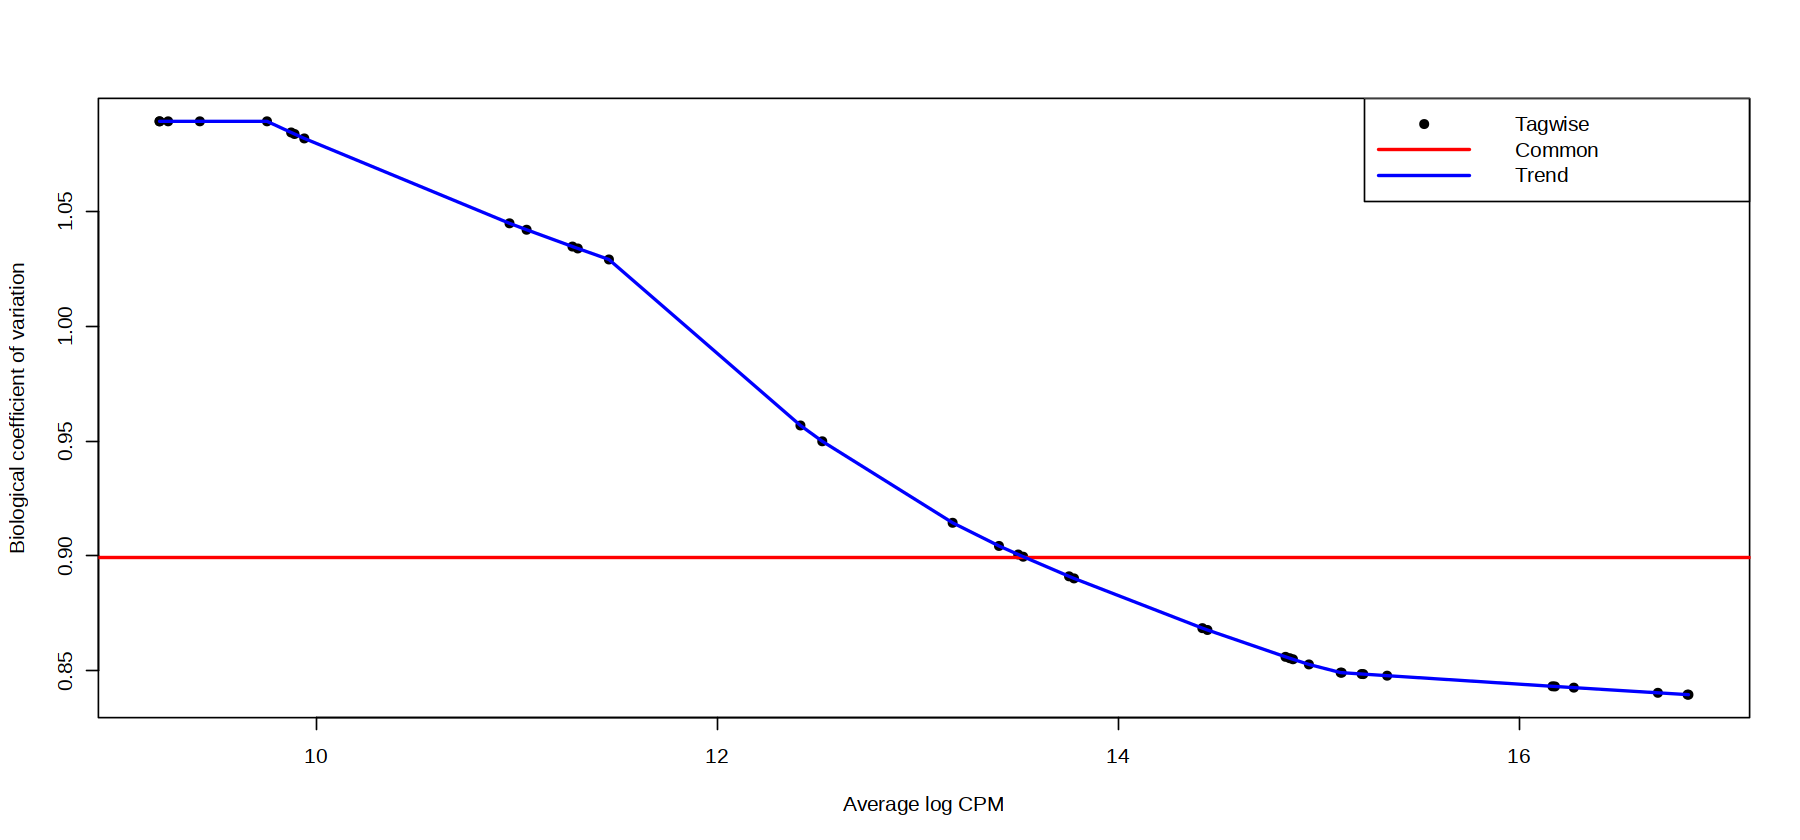

In [55]:
plotBCV(y.ab, cex=1)

In [56]:
fit.ab <- glmQLFit(y.ab, design, robust=TRUE, abundance.trend=FALSE)
summary(fit.ab$var.prior)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.402   1.402   1.402   1.402   1.402   1.402 

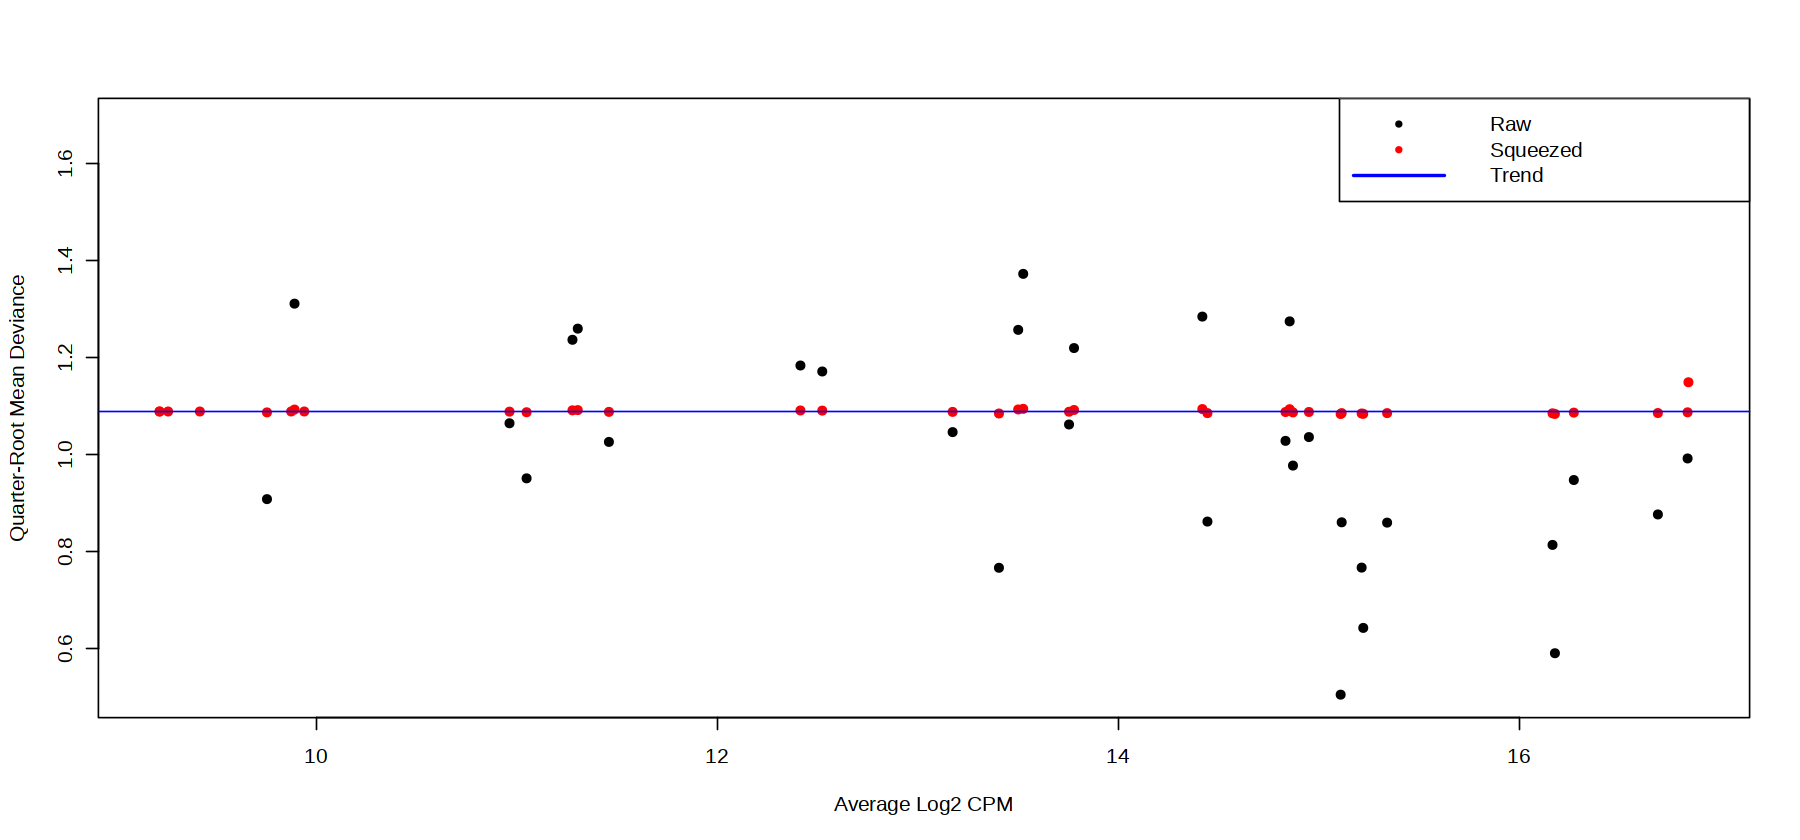

In [57]:
plotQLDisp(fit.ab, cex=1)

In [58]:
res <- glmQLFTest(fit.ab, coef=ncol(design))
summary(decideTests(res))

       tdTomTRUE
Down           0
NotSig        38
Up             0

In [59]:
res

An object of class "DGELRT"
$coefficients
                          (Intercept) factor(pool)pool2 factor(pool)pool3
Allantois                   -3.729149        1.41634299         0.9171019
Allantois_endothelium       -4.686265       -0.01770636         0.5597637
Amniotic_ectoderm           -5.636630        3.07718995         0.8101667
Anterior_Primitive_Streak   -8.878936       -0.71918028        -0.9515193
Blood_progenitors_1         -4.983783       -3.67950439        -1.2705024
                          factor(pool)pool4  tdTomTRUE
Allantois                        0.79184683  0.5036909
Allantois_endothelium            0.06598326  0.3686875
Amniotic_ectoderm                1.52465516  0.3085464
Anterior_Primitive_Streak       -1.22837260 -0.8170647
Blood_progenitors_1             -0.79835071 -2.5504481
33 more rows ...

$fitted.values
                          SLX-20795_SITTA11_HKTG2DRXY
Allantois                                5.947138e+01
Allantois_endothelium                    5.

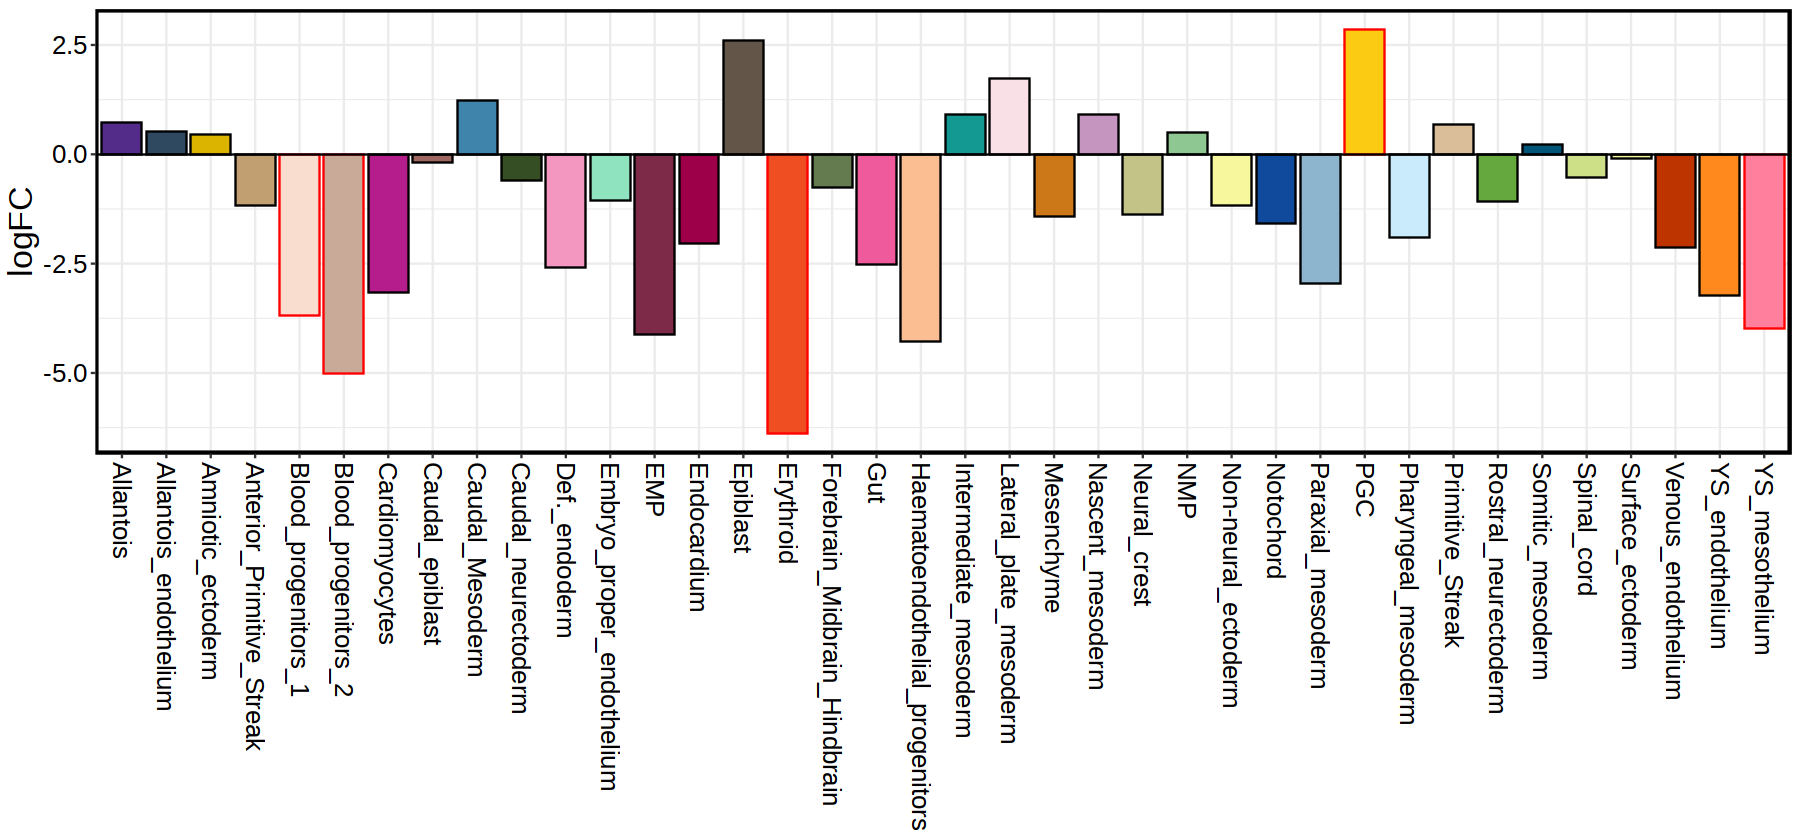

In [69]:
ggplot(as.data.table(res$table, keep.rownames=T), aes(rn, logFC, fill = rn, color = PValue<0.05)) + geom_bar(stat = 'identity')  +
    scale_fill_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    scale_color_manual(values=c('TRUE' = 'red', 'FALSE' = 'black')) + 
    geom_hline(yintercept=0) + 
    theme_bw() + 
        theme(legend.position = 'none', 
            axis.text = element_text(size=15, color='black'),
                          axis.text.x = element_text(size=15, color='black', angle=-90, hjust=0, vjust=0.5),

              axis.title = element_text(size=20, color='black'),
              axis.title.x = element_blank(), 
              legend.text = element_text(size=15),
              legend.title = element_text(size=20),
              plot.title = element_text(size=25),
              panel.border = element_rect(color='black', linewidth=1.3),
                       strip.background=element_blank(),
          strip.text.x = element_blank())

In [60]:
res$table

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
Allantois,0.72667230,16.272946,0.418185589,0.519143657
Allantois_endothelium,0.53190360,13.780137,0.163044551,0.687125236
Amniotic_ectoderm,0.44513840,14.872135,0.141774875,0.707222774
Anterior_Primitive_Streak,-1.17877516,9.219105,0.432533267,0.512074305
Blood_progenitors_1,-3.67951876,11.049745,4.074963066,0.045870262
Blood_progenitors_2,-5.01053398,13.526694,7.433322910,0.007414613
Cardiomyocytes,-3.17091489,13.501705,3.599684049,0.060320475
Caudal_Mesoderm,1.21939098,14.951658,1.042385181,0.309429154
Caudal_epiblast,-0.18522669,15.341738,0.028646398,0.865898023
